test generator

In [ ]:
#from data_generator import *

In [64]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

from skimage.draw import *

In [48]:
img = np.zeros((500, 500, 3), dtype=np.double)
img = np.zeros((500, 500, 3))

In [ ]:
x_radius = 50
y_radius = 20
alpha = 3*np.pi/7
beta = 3*np.pi/15
test = [[(((x-200)*np.cos(alpha) + (y-30)*np.sin(alpha) ) / x_radius) ** 2 + (((x-200)*np.sin(alpha) - (y-30)*np.cos(alpha)) / y_radius) ** 2 - 1 for x in range(500)] for y in range(500)]
noise = -np.random.rand(500,500)*10
blurred = gaussian_filter(noise,sigma=2)
test = np.array(test) + blurred
test = np.where(test < 0, 1, 0)

In [160]:
def generate_cell(c_x,c_y,x_radius,y_radius,alpha,img_size,noise_strength,sigma_blur, class_nbr=1):
    def ellipse(x,y):
        return (((x-c_x)*np.cos(alpha) + (y-c_y)*np.sin(alpha) ) / x_radius) ** 2 + (((x-c_x)*np.sin(alpha) - (y-c_y)*np.cos(alpha)) / y_radius) ** 2 - 1
    
    img = [[ellipse(x,y) for x in range(img_size)] for y in range(img_size)]
    noise = np.random.normal(0,noise_strength,(img_size,img_size))
    blur = gaussian_filter(noise,sigma=sigma_blur)
    img = np.where(np.array(img) + blur < 0, class_nbr, 0)
    return img

In [161]:
def generate_cells(nb_cells,img_size, base_img = None, class_nbr=1):
    if base_img == None:
        img = np.zeros((img_size,img_size))
    else:
        img = base_img
    i = 0
    while i < nb_cells:
        c_x = np.random.randint(-10, img_size + 10)
        c_y = np.random.randint(-10, img_size + 10)
        x_radius = np.random.randint(25,55)
        y_radius = np.random.randint(25,55)
        alpha = np.random.uniform(0,2 *np.pi)
        temp_img = generate_cell(c_x,c_y,x_radius,y_radius,alpha,img_size,noise_strength = 2,sigma_blur=3.7, class_nbr = 1)
        if(np.sum(np.multiply(img,temp_img)) == 0):
            i+=1
            img+=temp_img
    return img

In [162]:
image = generate_cells(7,256)

In [163]:
bg_noise = np.random.normal(0,1,(256,256))
cell_1_noise = gaussian_filter(np.random.normal(2,3,(256,256)), sigma=2)
final_img = np.zeros((256,256))
print(bg_noise.shape)
final_img = np.where(image==1,cell_1_noise,bg_noise)


(256, 256)


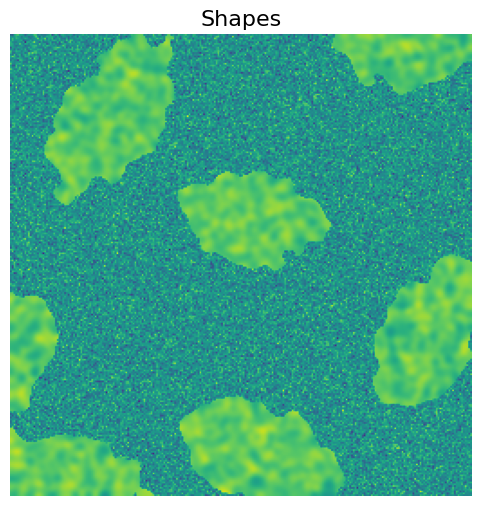

In [164]:
fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax1.imshow(final_img)
ax1.set_title('Shapes',fontsize=16)
ax1.axis('off')
plt.show()

In [165]:
from skimage import io, util
import os
image_u8 = util.img_as_ubyte(final_img/np.max(np.abs(final_img)))
io.imsave(os.path.join('',  f"3.png"), image_u8)